In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/sirius courses/courses/courses'

def course_info(course_id): #возвращает словарь, где ключи -- названия таблиц, значения -- сами таблицы, для соответствующего курса
    course_info = {}
    directory = os.fsencode(path + '/' + str(course_id))
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        course_info[filename[:-4]] = pd.read_csv(path + '/' + str(course_id) + '/' + filename, index_col=False)
    return course_info

def dict_union(dict1, dict2):
    new_dict = {}
    for key in dict1.keys():
        if key in dict2.keys():
            new_dict[key] = pd.concat([dict1[key], dict2[key]])
        else:
            new_dict[key] = dict1[key]
    return new_dict

def all_courses_info():  #возвращает словарь, где ключи -- названия таблиц, значения -- сами таблицы, для всех курсов
    all_courses = {}
    directory = os.fsencode(path)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        course = course_info(filename)
        all_courses = dict_union(course, all_courses)
    return all_courses

all_courses_info = all_courses_info()

In [ ]:
tasks = all_courses_info['user_element_progress'][(all_courses_info['user_element_progress']["course_element_type"] == "task") &
                                                (all_courses_info['user_element_progress']["achieve_reason"] != "transferred") &
                                                (all_courses_info['user_element_progress']["course_id"] != 1880)]

## trivial_module_metric

для каждого пользователя посчитаем "процент прохождения модуля" -- отношение количества решенных задач к общему количеству задач в модуле, и усредним по всем пользователем

In [ ]:
modules = np.unique(np.array(tasks['course_module_id']))
metric_values = []
for module_id in modules:
    if all_courses_info['course_module'][all_courses_info['course_module']['id'] == module_id]['is_advanced'].iloc[0]:
        continue
    tasks_module = tasks[tasks['course_module_id'] == module_id]
    users = np.unique(np.array(tasks_module['user_id']))
    percent_for_user = []
    for user in users:
        user_tasks = tasks_module[tasks_module['user_id'] == user]
        achieved_tasks = user_tasks[user_tasks['is_achieved'] == True]
        percent_for_user.append(len(achieved_tasks) / len(user_tasks))
    metric_values.append(round(np.mean(percent_for_user), 2))

<Axes: ylabel='Count'>

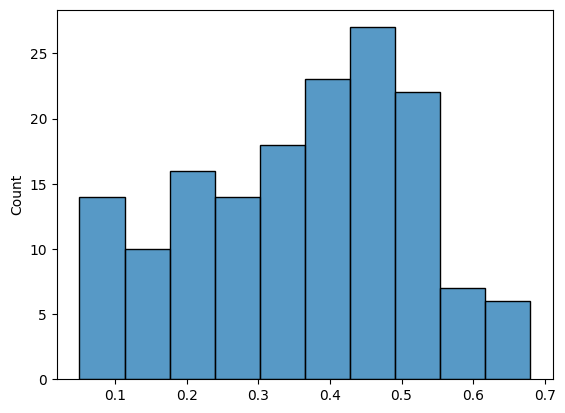

In [ ]:
metric_values = np.array(metric_values)
metric_values_non_zero = metric_values[metric_values != 0]

sns.histplot(metric_values_non_zero, bins = 10)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/sirius courses/courses/courses/1038_1212_1316_1555_1738_1880'
ml_course_info = {}
directory = os.fsencode(path)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    ml_course_info[filename[:-4]] = pd.read_csv(path + '/' + filename)

In [ ]:
ml_tasks = ml_course_info['user_element_progress'][(ml_course_info['user_element_progress']["course_element_type"] == "task") &
                                                (ml_course_info['user_element_progress']["achieve_reason"] != "transferred") &
                                                (ml_course_info['user_element_progress']["course_id"] == 1555) ]

In [ ]:
def trivial_module_metric(threshold=0.3):
    modules = np.unique(np.array(ml_tasks['course_module_id']))
    metric_values = {}
    for module_id in modules:
        if ml_course_info['course_module'][ml_course_info['course_module']['id'] == module_id]['is_advanced'].iloc[0]:
            continue
        tasks_module = ml_tasks[ml_tasks['course_module_id'] == module_id]
        users = np.unique(np.array(tasks_module['user_id']))
        percent_for_user = []
        for user in users:
            user_tasks = tasks_module[tasks_module['user_id'] == user]
            achieved_tasks = user_tasks[user_tasks['is_achieved'] == True]
            percent_for_user.append(len(achieved_tasks) / len(user_tasks))
        metric_values[module_id] = (round(np.mean(percent_for_user), 2), round(np.mean(percent_for_user), 2) < threshold)
    return metric_values

print(trivial_module_metric())

{14585: (0.37, False), 14586: (0.37, False), 14587: (0.34, False), 14588: (0.33, False), 14589: (0.32, False), 14590: (0.37, False), 14591: (0.28, True), 14592: (0.26, True), 14593: (0.37, False), 14597: (0.31, False)}


## average_tries_count

для каждого пользователя посчитаем среднее количество попыток, затрачиваемое на задачу внутри модуля, и усредним по всем пользователям

In [ ]:
modules = np.unique(np.array(tasks['course_module_id']))
metric_values = []
for module_id in modules:
    if all_courses_info['course_module'][all_courses_info['course_module']['id'] == module_id]['is_advanced'].iloc[0]:
        continue
    tasks_module = tasks[tasks['course_module_id'] == module_id]
    users = np.unique(np.array(tasks_module['user_id']))
    avg_tries_for_user = []
    for user in users:
        user_tasks = tasks_module[(tasks_module['user_id'] == user) & (tasks_module['tries_count'] > 0)]
        all_tries = np.array(user_tasks['tries_count']).sum()
        if len(user_tasks) != 0:
            avg_tries_for_user.append(all_tries / len(user_tasks))
    metric_values.append(round(np.mean(avg_tries_for_user), 2))

[ 5.07  8.86  3.49  3.01  5.15  3.34  2.69  3.66  4.67  4.76  5.59  8.88
  2.55  2.08  2.04  1.42  2.34  1.37  1.77  2.35  2.48  2.32  1.96  2.69
  1.7   2.46  5.3   2.59  1.36  1.42  2.21  3.37  7.08  3.72  3.22  3.27
  2.85  2.88  2.03  3.11  3.9   3.64  2.69  2.42  2.25  3.3   1.32  2.76
  1.9   1.87  1.67  2.07  1.83  1.94  1.52  1.64  1.65  1.71  1.87  2.37
  2.63  1.81  2.47  1.69  1.45  1.64  1.37  2.44  1.36  3.13  1.51  6.56
  2.85  1.36  1.59  1.36  1.82  1.21  2.02  1.92  1.79  1.55  2.23  2.86
  5.82  5.53  2.41  3.37  2.83 10.77 18.68  4.2   4.52  2.02  5.53  7.49
  4.85  6.66  1.55  3.75  1.6   5.51  2.03  3.46  1.67  6.48  7.3   2.25
  2.6   2.39  4.15  3.31  4.59  3.74  8.85  4.2   9.34  1.52  2.05  2.13
  4.06  3.05  4.07  3.97  5.24  3.47  5.86  3.68  2.95  2.08  3.09  3.76
  4.93  3.82  1.55  2.09  3.88  3.7   6.28  9.06  6.46  2.45  3.18  1.65
  4.08  3.02  2.31  2.8   2.89  3.27  4.41  1.81  3.28  1.53  3.43  2.86
  1.92]


<Axes: ylabel='Count'>

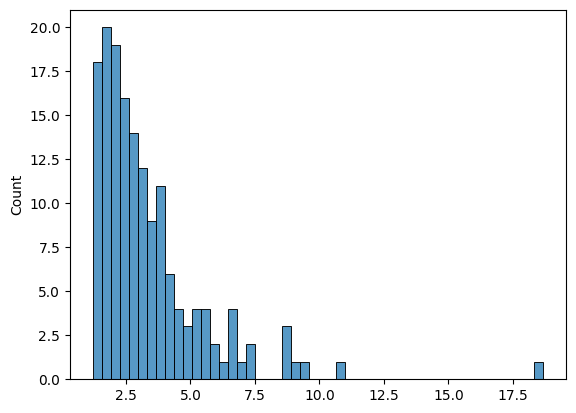

In [ ]:
metric_values = np.array(metric_values)
metric_values_non_zero = metric_values[metric_values != 0]
print(metric_values_non_zero)

sns.histplot(metric_values_non_zero, bins = 50)

In [ ]:
def average_tries_count(threshold=4):
    modules = np.unique(np.array(ml_tasks['course_module_id']))
    metric_values = {}
    for module_id in modules:
        if ml_course_info['course_module'][ml_course_info['course_module']['id'] == module_id]['is_advanced'].iloc[0]:
            continue
        tasks_module = ml_tasks[ml_tasks['course_module_id'] == module_id]
        users = np.unique(np.array(tasks_module['user_id']))
        avg_tries_for_user = []
        for user in users:
            user_tasks = tasks_module[(tasks_module['user_id'] == user) & (tasks_module['tries_count'] > 0)]
            all_tries = np.array(user_tasks['tries_count']).sum()
            if len(user_tasks) != 0:
                avg_tries_for_user.append(all_tries / len(user_tasks))
        metric_values[module_id] = (round(np.mean(avg_tries_for_user), 2), round(np.mean(avg_tries_for_user), 2) > threshold)
    return metric_values

print(average_tries_count())

{14585: (3.7, False), 14586: (6.28, True), 14587: (9.06, True), 14588: (6.46, True), 14589: (2.45, False), 14590: (3.18, False), 14591: (1.65, False), 14592: (4.08, True), 14593: (3.02, False), 14597: (2.31, False)}
